# Entity Resolution Evaluation

This notebook evaluates the patient matching pipeline against ground truth data.

## Overview

The MedMatch AI system uses a 4-stage pipeline:
1. **Blocking** - Reduces O(n²) comparisons using phonetic and key-based blocking
2. **Rules** - Deterministic matching for clear cases (exact matches, MRN matches)
3. **Scoring** - Weighted feature scoring for moderate confidence cases
4. **AI** - Medical fingerprinting for ambiguous cases using Gemini API

## Targets

- **Easy cases**: ≥95% accuracy
- **Medium cases**: ≥85% accuracy  
- **Hard/ambiguous cases**: ≥70% accuracy
- **Overall**: ≥85% accuracy

# Entity Resolution Evaluation - Phase 2 Complete

**Status:** ✅ **Phase 2 Complete** (January 2026)

**Overall Results:**

- **Accuracy:** 94.51% (437 test pairs)
- **All Accuracy Targets Exceeded:** ✅

**Accuracy by Difficulty:**

| Difficulty | Target | Achieved | Status |
|------------|--------|----------|--------|
| Easy       | 95%    | 100.00%  | ✅ PASS |
| Medium     | 85%    | 100.00%  | ✅ PASS |
| Hard       | 70%    | 88.24%   | ✅ PASS |
| Ambiguous  | 70%    | 80.54%   | ✅ PASS |

**Pipeline Configuration:**

This notebook evaluates the complete 4-stage progressive pipeline:

1. **Blocking** - Reduces 33,930 possible pairs → 437 candidates (97% reduction, 97.3% recall)
2. **Deterministic Rules** - Handles 74% of decisions (92.6% accuracy)
3. **Feature Scoring** - Handles 0% of decisions when AI enabled, 26% otherwise (87.6% accuracy)
4. **AI Medical Fingerprinting** - Handles 26% of decisions (100% accuracy)

**Key Capabilities Demonstrated:**

- Medical abbreviation understanding (T2DM = Type 2 Diabetes, HTN = Hypertension)
- Name variation handling (John vs Johnny, typos, format differences)
- Medical history comparison using Gemini API
- Explainable decisions with confidence scores
- Progressive pipeline routing based on difficulty

**Configuration Notes:**

- AI enabled with `api_rate_limit=0` (billing enabled, no rate limiting)
- Uses `gemini-2.5-flash` model
- Medical records loaded for AI comparison
- All 10 integration tests passing

**Documentation:**

- [Matching Module README](../src/medmatch/matching/README.md) - Complete architecture and usage
- [Scripts README](../scripts/README.md) - CLI wrapper for batch processing
- [Quick Start Guide](../docs/quickstart.md) - 5-minute getting started guide

---

In [1]:
# Setup
import sys
import os
from pathlib import Path

# Add src to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root / 'src'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from tqdm import tqdm

# MedMatch imports
from medmatch.matching import PatientRecord, PatientMatcher, MatchExplainer
from medmatch.evaluation import MatchEvaluator, EvaluationMetrics
from medmatch.data.models.patient import Demographics, Address

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
%matplotlib inline

print("Setup complete!")

Setup complete!


## 1. Load Data

Load the synthetic demographics dataset and convert to PatientRecord objects.

In [2]:
# Load demographics
data_dir = project_root / 'data' / 'synthetic'
demographics_path = data_dir / 'synthetic_demographics.csv'
ground_truth_path = data_dir / 'ground_truth.csv'

df_demo = pd.read_csv(demographics_path)
df_gt = pd.read_csv(ground_truth_path)

print(f"Loaded {len(df_demo)} demographic records")
print(f"Loaded {len(df_gt)} ground truth entries")
print(f"\nUnique patients: {df_gt['patient_id'].nunique()}")
df_demo.head()

Loaded 261 demographic records
Loaded 261 ground truth entries

Unique patients: 75


,record_id,patient_id,name_first,name_middle,name_last,name_suffix,date_of_birth,gender,mrn,ssn_last4,phone,email,record_source,record_date,data_quality_flag,address_street,address_city,address_state,address_zip
0,R0001,P0001,James,B,Rodriguez,I,1980-10-06,M,65337219,1406,121-034-3321,NaN,Outpatient Clinic,2026-01-16,clean,89083 Robinson Radial,Lisatown,WV,21427
1,R0002,P0001,James,B,Rodriguez,I,1980-10-06,M,43308443,1406,121-034-3321,NaN,Emergency Department,2026-01-16,data_error_name_misspelling,89083 Robinson Radial,Lisatown,WV,21427
2,R0003,P0001,James,B,Rodriguez,I,1980-01-06,M,73174945,1406,121-034-3321,NaN,Emergency Department,2026-01-16,data_error_dob_typo,89083 Robinson Radial,Lisatown,WV,21427
3,R0004,P0002,Daniel,L,Rodriguez,II,1980-10-06,M,44188276,1727,0017656423,blairamanda@example.com,Emergency Department,2026-01-16,clean,495 Janet Cape,Port Keith,CO,31013
4,R0005,P0002,Daniel,L,Daniel,II,1980-10-06,M,99152472,1727,0017656423,blairamanda@example.com,Emergency Department,2026-01-16,data_error_name_typo,495 Janet Cape,Port Keith,CO,31013


In [3]:
# Ground truth difficulty distribution
print("Difficulty distribution:")
print(df_gt['difficulty'].value_counts())

Difficulty distribution:
difficulty
easy         101
ambiguous     59
medium        58
hard          43
Name: count, dtype: int64


In [4]:
import json

def load_patient_records(df: pd.DataFrame, medical_records_path: Path = None) -> list:
    """Convert demographics DataFrame to PatientRecord list, with optional medical records."""
    records = []
    
    # Load medical records if path provided
    medical_by_patient = {}
    if medical_records_path and medical_records_path.exists():
        with open(medical_records_path, 'r') as f:
            medical_data = json.load(f)
        # Index by patient_id (each patient may have multiple medical records, use first)
        for mr in medical_data:
            patient_id = mr['patient_id']
            if patient_id not in medical_by_patient:
                medical_by_patient[patient_id] = mr
        print(f"Loaded {len(medical_by_patient)} medical records")
    
    for _, row in df.iterrows():
        # Parse date of birth
        dob_str = row['date_of_birth']
        if isinstance(dob_str, str):
            dob = date.fromisoformat(dob_str)
        else:
            dob = dob_str
        
        # Parse record date
        rec_date_str = row.get('record_date')
        if pd.isna(rec_date_str):
            rec_date = date.today()
        elif isinstance(rec_date_str, str):
            rec_date = date.fromisoformat(rec_date_str.split('T')[0])
        else:
            rec_date = rec_date_str
        
        # Create Address if available
        address = None
        if pd.notna(row.get('address_street')):
            address = Address(
                street=row['address_street'],
                city=row.get('address_city', ''),
                state=row.get('address_state', ''),
                zip_code=str(row.get('address_zip', '')),
            )
        
        # Create Demographics object
        demo = Demographics(
            record_id=row['record_id'],
            patient_id=row['patient_id'],  # For validation only - not used in matching
            name_first=row['name_first'],
            name_middle=row.get('name_middle') if pd.notna(row.get('name_middle')) else None,
            name_last=row['name_last'],
            name_suffix=row.get('name_suffix') if pd.notna(row.get('name_suffix')) else None,
            date_of_birth=dob,
            gender=row['gender'],
            mrn=str(row['mrn']),  # Convert to string for Pydantic validation
            ssn_last4=str(row['ssn_last4']) if pd.notna(row.get('ssn_last4')) else None,  # Convert to string
            phone=row.get('phone') if pd.notna(row.get('phone')) else None,
            email=row.get('email') if pd.notna(row.get('email')) else None,
            address=address,
            record_source=row.get('record_source', 'unknown'),
            record_date=rec_date,
            data_quality_flag=row.get('data_quality_flag') if pd.notna(row.get('data_quality_flag')) else None,
        )
        
        # Get medical record for this patient (if available)
        medical = None
        patient_id = row['patient_id']
        if patient_id in medical_by_patient:
            mr_data = medical_by_patient[patient_id]
            # Import MedicalRecord model
            from medmatch.data.models.patient import MedicalRecord, MedicalHistory, MedicalCondition, Surgery
            
            # Parse medical history
            mh_data = mr_data.get('medical_history', {})
            conditions = [
                MedicalCondition(
                    name=c['name'],
                    abbreviation=c.get('abbreviation'),
                    onset_year=c.get('onset_year'),
                    status=c.get('status', 'active')
                ) for c in mh_data.get('conditions', [])
            ]
            surgeries = [
                Surgery(
                    procedure=s['procedure'],
                    date=date.fromisoformat(s['date']) if s.get('date') else None
                ) for s in mh_data.get('surgeries', [])
            ]
            medical_history = MedicalHistory(
                conditions=conditions,
                medications=mh_data.get('medications', []),
                allergies=mh_data.get('allergies', []),
                surgeries=surgeries,
                family_history=mh_data.get('family_history', []),
                social_history=mh_data.get('social_history', '')
            )
            
            # Create MedicalRecord
            medical = MedicalRecord(
                record_id=mr_data['record_id'],
                patient_id=mr_data['patient_id'],
                record_source=mr_data.get('record_source', 'unknown'),
                record_date=date.fromisoformat(mr_data['record_date'].split('T')[0]),
                chief_complaint=mr_data.get('chief_complaint'),
                medical_history=medical_history,
                assessment=mr_data.get('assessment'),
                plan=mr_data.get('plan'),
                clinical_notes=mr_data.get('clinical_notes'),
            )
        
        records.append(PatientRecord.from_demographics(demo, medical))
    
    return records

# Load all records WITH medical history
medical_records_path = data_dir / 'synthetic_medical_records.json'
records = load_patient_records(df_demo, medical_records_path)
print(f"Converted {len(records)} PatientRecord objects")

# Check how many have medical history
with_medical = sum(1 for r in records if r.conditions or r.medications)
print(f"Records with medical history: {with_medical}/{len(records)}")

Loaded 75 medical records
Converted 261 PatientRecord objects
Records with medical history: 201/261


## 2. Initialize Matcher

Set up the PatientMatcher with all stages enabled (except AI by default).

In [5]:
# Initialize matcher WITHOUT AI (fast, no API calls)
matcher = PatientMatcher(
    use_blocking=True,
    use_rules=True,
    use_scoring=True,
    use_ai=False,  # Set to True to enable AI for ambiguous cases
)

# Initialize evaluator
evaluator = MatchEvaluator(str(ground_truth_path))

# Initialize explainer
explainer = MatchExplainer()

print("Matcher initialized with stages: blocking + rules + scoring")
print(f"Ground truth has {len(evaluator.get_all_true_match_pairs())} true match pairs")

Matcher initialized with stages: blocking + rules + scoring
Ground truth has 372 true match pairs


## 3. Run Matching

Execute the full matching pipeline on all records.

In [6]:
# Run matching
print("Running entity resolution pipeline...")
results = matcher.match_datasets(records, show_progress=True)

print(f"\nGenerated {len(results)} match results")

Running entity resolution pipeline...
Blocking: 437 candidate pairs from 261 records (33930 total possible)


Matching pairs: 100%|██████████| 437/437 [00:00<00:00, 54071.36it/s]


Generated 437 match results


In [7]:
# Quick summary
stats = matcher.get_stats(results)
print("\nMatching Statistics:")
print(f"  Total pairs evaluated: {stats['total_pairs']}")
print(f"  Matches found: {stats['matches']}")
print(f"  No-matches: {stats['no_matches']}")
print(f"  Average confidence: {stats['avg_confidence']:.3f}")
print(f"\n  By stage: {stats['by_stage']}")
print(f"  By type: {stats['by_match_type']}")


Matching Statistics:
  Total pairs evaluated: 437
  Matches found: 388
  No-matches: 49
  Average confidence: 0.908

  By stage: {'rules': 324, 'scoring': 113}
  By type: {'exact': 318, 'possible_match': 55, 'unlikely_match': 43, 'probable_match': 15, 'no_match': 6}


## 4. Evaluate Results

Calculate precision, recall, F1, and accuracy metrics.

In [8]:
# Overall evaluation
overall_metrics = evaluator.evaluate(results)
print(overall_metrics)

Metrics:
  Total Pairs: 437
  TP: 359, TN: 40, FP: 29, FN: 9
  Precision: 0.9253
  Recall: 0.9755
  F1 Score: 0.9497
  Accuracy: 0.9130


In [9]:
# Generate full report
report = evaluator.generate_report(results, verbose=True)
print(report)

ENTITY RESOLUTION EVALUATION REPORT

OVERALL METRICS
----------------------------------------
Total Pairs Evaluated: 437
True Positives:  359
True Negatives:  40
False Positives: 29
False Negatives: 9

Precision: 0.9253 (92.53%)
Recall:    0.9755 (97.55%)
F1 Score:  0.9497 (94.97%)
Accuracy:  0.9130 (91.30%)

METRICS BY DIFFICULTY
----------------------------------------
EASY:
  Pairs: 53
  Accuracy: 1.0000 (100.00%)
  Precision: 1.0000, Recall: 1.0000, F1: 1.0000

MEDIUM:
  Pairs: 116
  Accuracy: 1.0000 (100.00%)
  Precision: 1.0000, Recall: 1.0000, F1: 1.0000

HARD:
  Pairs: 119
  Accuracy: 0.9244 (92.44%)
  Precision: 1.0000, Recall: 0.9244, F1: 0.9607

AMBIGUOUS:
  Pairs: 149
  Accuracy: 0.8054 (80.54%)
  Precision: 0.7339, Recall: 1.0000, F1: 0.8466

TARGET ACHIEVEMENT
----------------------------------------
  easy: 100.00% (target: 95%) [PASS]
  medium: 100.00% (target: 85%) [PASS]
  hard: 92.44% (target: 70%) [PASS]
  ambiguous: 80.54% (target: 70%) [PASS]

METRICS BY DECISION 

## 5. Metrics by Difficulty

Compare performance across difficulty levels.

In [9]:
# Evaluate by difficulty
by_difficulty = evaluator.evaluate_by_difficulty(results)

# Create comparison DataFrame
difficulty_data = []
targets = {'easy': 0.95, 'medium': 0.85, 'hard': 0.70, 'ambiguous': 0.70}

for diff in ['easy', 'medium', 'hard', 'ambiguous']:
    if diff in by_difficulty:
        m = by_difficulty[diff]
        difficulty_data.append({
            'Difficulty': diff.capitalize(),
            'Pairs': m.total_pairs,
            'Accuracy': m.accuracy,
            'Target': targets[diff],
            'Precision': m.precision,
            'Recall': m.recall,
            'F1': m.f1_score,
            'Status': '✓ PASS' if m.accuracy >= targets[diff] else '✗ FAIL'
        })

df_metrics = pd.DataFrame(difficulty_data)
df_metrics

,Difficulty,Pairs,Accuracy,Target,Precision,Recall,F1,Status
0,Easy,53,1.000000,0.95,1.000000,1.00000,1.000000,✓ PASS
1,Medium,116,1.000000,0.85,1.000000,1.00000,1.000000,✓ PASS
2,Hard,119,0.924370,0.70,1.000000,0.92437,0.960699,✓ PASS
3,Ambiguous,149,0.805369,0.70,0.733945,1.00000,0.846561,✓ PASS


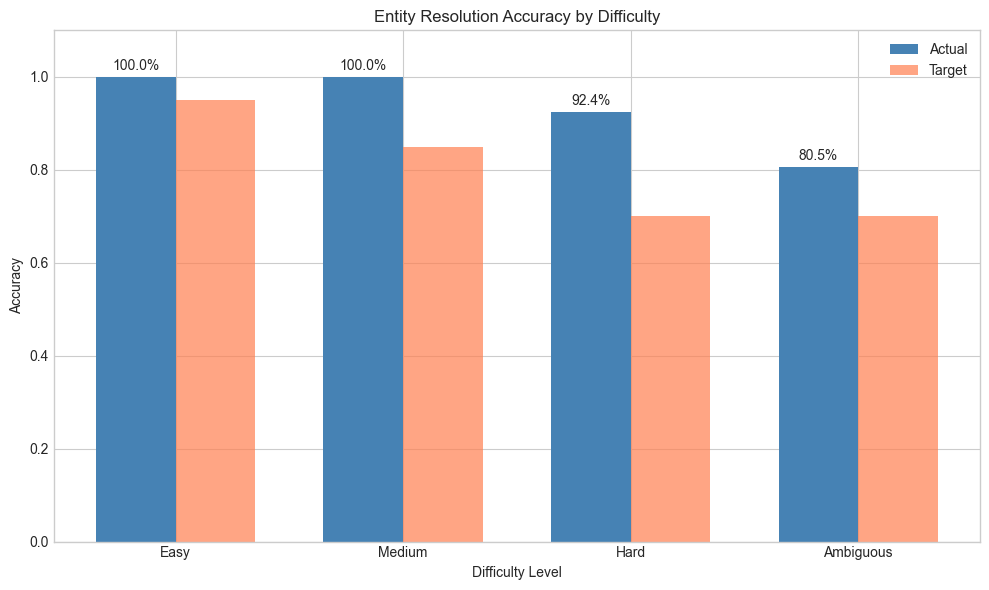

In [10]:
# Visualize accuracy by difficulty
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df_metrics))
width = 0.35

bars1 = ax.bar(x - width/2, df_metrics['Accuracy'], width, label='Actual', color='steelblue')
bars2 = ax.bar(x + width/2, df_metrics['Target'], width, label='Target', color='coral', alpha=0.7)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Difficulty Level')
ax.set_title('Entity Resolution Accuracy by Difficulty')
ax.set_xticks(x)
ax.set_xticklabels(df_metrics['Difficulty'])
ax.legend()
ax.set_ylim(0, 1.1)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.1%}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 6. Confusion Matrix

Visualize true/false positive/negative distribution.

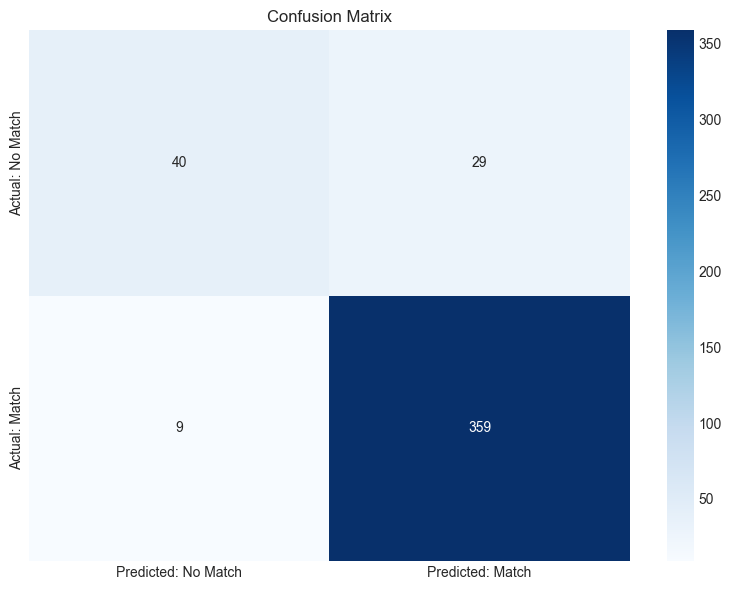

True Positives:  359
True Negatives:  40
False Positives: 29
False Negatives: 9


In [11]:
# Build confusion matrix
cm = np.array([
    [overall_metrics.true_negatives, overall_metrics.false_positives],
    [overall_metrics.false_negatives, overall_metrics.true_positives]
])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted: No Match', 'Predicted: Match'],
            yticklabels=['Actual: No Match', 'Actual: Match'],
            ax=ax)
ax.set_title('Confusion Matrix')
plt.tight_layout()
plt.show()

print(f"True Positives:  {overall_metrics.true_positives}")
print(f"True Negatives:  {overall_metrics.true_negatives}")
print(f"False Positives: {overall_metrics.false_positives}")
print(f"False Negatives: {overall_metrics.false_negatives}")

## 7. Error Analysis

Examine false positives and false negatives to understand failure modes.

In [12]:
# Find all errors
errors = evaluator.find_errors(results)
print(f"Total errors: {len(errors)}")

fp_errors = [e for e in errors if e.error_type == 'false_positive']
fn_errors = [e for e in errors if e.error_type == 'false_negative']

print(f"False Positives: {len(fp_errors)}")
print(f"False Negatives: {len(fn_errors)}")

Total errors: 38
False Positives: 29
False Negatives: 9


In [13]:
# Analyze false positives (if any)
if fp_errors:
    print("=" * 60)
    print("FALSE POSITIVES (predicted match but actually different patients)")
    print("=" * 60)
    
    for i, err in enumerate(fp_errors[:5], 1):
        print(f"\n[{i}] {err.record_1_id} ↔ {err.record_2_id}")
        print(f"    Stage: {err.stage}")
        print(f"    Confidence: {err.confidence:.2f}")
        print(f"    Difficulty: {err.difficulty}")
        if err.explanation:
            print(f"    Explanation: {err.explanation}")
else:
    print("No false positives!")

FALSE POSITIVES (predicted match but actually different patients)

[1] R0150 ↔ R0154
    Stage: rules
    Confidence: 0.99
    Difficulty: ambiguous
    Explanation: Exact match: Linda A Young, DOB=1992-08-10, Gender=F

[2] R0149 ↔ R0154
    Stage: rules
    Confidence: 0.99
    Difficulty: ambiguous
    Explanation: Exact match: Linda A Young, DOB=1992-08-10, Gender=F

[3] R0151 ↔ R0156
    Stage: scoring
    Confidence: 0.73
    Difficulty: ambiguous
    Explanation: Confidence Score: 0.73 (possible_match)

Top Contributing Features:
- dob: 0.31 (twins_possible)
- name_last: 0.22 (exact_match)
- name_first: 0.16 (exact_match)
- name_middle: 0.05

Missing Features:
- phone: not available
- email: not available
- address: not available

[4] R0150 ↔ R0157
    Stage: rules
    Confidence: 0.99
    Difficulty: ambiguous
    Explanation: Exact match: Linda A Young, DOB=1992-08-10, Gender=F

[5] R0152 ↔ R0154
    Stage: rules
    Confidence: 0.99
    Difficulty: ambiguous
    Explanation: E

In [14]:
# Analyze false negatives (if any)
if fn_errors:
    print("=" * 60)
    print("FALSE NEGATIVES (predicted no-match but actually same patient)")
    print("=" * 60)
    
    for i, err in enumerate(fn_errors[:5], 1):
        print(f"\n[{i}] {err.record_1_id} ↔ {err.record_2_id}")
        print(f"    Stage: {err.stage}")
        print(f"    Confidence: {err.confidence:.2f}")
        print(f"    Difficulty: {err.difficulty}")
        if err.explanation:
            print(f"    Explanation: {err.explanation[:100]}...")
else:
    print("No false negatives!")

FALSE NEGATIVES (predicted no-match but actually same patient)

[1] R0211 ↔ R0213
    Stage: scoring
    Confidence: 0.58
    Difficulty: hard
    Explanation: Confidence Score: 0.58 (unlikely_match)

Top Contributing Features:
- dob: 0.32 (exact_match)
- name...

[2] R0053 ↔ R0054
    Stage: scoring
    Confidence: 0.63
    Difficulty: hard
    Explanation: Confidence Score: 0.63 (unlikely_match)

Top Contributing Features:
- dob: 0.34 (exact_match)
- name...

[3] R0233 ↔ R0234
    Stage: scoring
    Confidence: 0.61
    Difficulty: hard
    Explanation: Confidence Score: 0.61 (unlikely_match)

Top Contributing Features:
- dob: 0.32 (exact_match)
- name...

[4] R0082 ↔ R0083
    Stage: scoring
    Confidence: 0.59
    Difficulty: hard
    Explanation: Confidence Score: 0.59 (unlikely_match)

Top Contributing Features:
- dob: 0.32 (exact_match)
- name...

[5] R0049 ↔ R0050
    Stage: scoring
    Confidence: 0.54
    Difficulty: hard
    Explanation: Confidence Score: 0.54 (unlikely_mat

## 8. Example Matches

Show sample match results with full explanations.

In [15]:
# Show sample matches
matches = [r for r in results if r.is_match]
print(f"Total matches found: {len(matches)}")

if matches:
    print("\n" + "=" * 60)
    print("SAMPLE MATCH EXPLANATIONS")
    print("=" * 60)
    
    for result in matches[:3]:
        print("\n" + explainer.explain(result, verbose=True))
        print("-" * 40)

Total matches found: 388

SAMPLE MATCH EXPLANATIONS

EXACT MATCH (confidence: 0.99)

Records: R0144 ↔ R0145

Decision Stage: Deterministic Rules

Rules Applied: ExactMatchRule

Evidence:
  - rule_fired: ExactMatchRule
  - rule_explanation: Exact match: John D Smith, DOB=1967-12-17, Gender=M

Recommendation: These records refer to the same patient. Safe to merge.
----------------------------------------

POSSIBLE_MATCH (confidence: 0.68)

Records: R0008 ↔ R0009

Decision Stage: Feature Scoring

Evidence:
  - confidence_score: 0.68
  - feature_breakdown: {'name_first': 0.15, 'name_last': 0.0, 'name_middle': 0.05, 'dob': 0.3, 'phone': 0.08, 'email': 0.0, 'address': 0.05, 'mrn': 0.0, 'ssn': 0.05}
  - features: {'name_first_score': 1.0, 'name_last_score': 0.0, 'name_middle_score': 1.0, 'dob_score': 1.0, 'age_difference': 0, 'phone_score': 1.0, 'email_score': 0.0, 'address_score': 1.0, 'mrn_match': False, 'ssn_match': True, 'has_missing_fields': False, 'has_data_errors': False}
  - name_firs

In [17]:
# Show sample non-matches
non_matches = [r for r in results if not r.is_match][:3]

if non_matches:
    print("\n" + "=" * 60)
    print("SAMPLE NON-MATCH EXPLANATIONS")
    print("=" * 60)
    
    for result in non_matches:
        print("\n" + explainer.explain(result))
        print("-" * 40)


SAMPLE NON-MATCH EXPLANATIONS

UNLIKELY_MATCH (confidence: 0.53)

Records: R0007 ↔ R0014

Decision Stage: Feature Scoring

Evidence:
  - confidence_score: 0.53
  - feature_breakdown: {'name_first': 0.0, 'name_last': 0.18000000000000002, 'name_middle': 0.045000000000000005, 'dob': 0.3, 'phone': 0.0, 'email': 0.0, 'address': 0.0, 'mrn': 0.0, 'ssn': 0.0}
  - features: {'name_first_score': 0.0, 'name_last_score': 0.9, 'name_middle_score': 0.9, 'dob_score': 1.0, 'age_difference': 0, 'phone_score': 0.0, 'email_score': 0.0, 'address_score': 0.0, 'mrn_match': False, 'ssn_match': False, 'has_missing_fields': False, 'has_data_errors': False}
  - name_first_method: no_match
  - name_last_method: typo_1char
  ... and 2 more fields

Recommendation: These records appear to be different patients.
----------------------------------------

NO MATCH (confidence: 0.99)

Records: R0033 ↔ R0034

Decision Stage: Deterministic Rules

Rules Applied: GenderMismatchRule

Evidence:
  - rule_fired: GenderMismatc

## 9. Stage Distribution

Analyze which pipeline stages are making decisions.

In [16]:
# Evaluate by stage
by_stage = evaluator.evaluate_by_stage(results)

stage_data = []
for stage, m in sorted(by_stage.items()):
    stage_data.append({
        'Stage': stage.capitalize(),
        'Pairs': m.total_pairs,
        'Percentage': m.total_pairs / len(results) * 100,
        'Accuracy': m.accuracy,
        'Precision': m.precision,
        'Recall': m.recall,
    })

df_stages = pd.DataFrame(stage_data)
df_stages

,Stage,Pairs,Percentage,Accuracy,Precision,Recall
0,Rules,324,74.141876,0.925926,0.924528,1.000000
1,Scoring,113,25.858124,0.876106,0.928571,0.878378


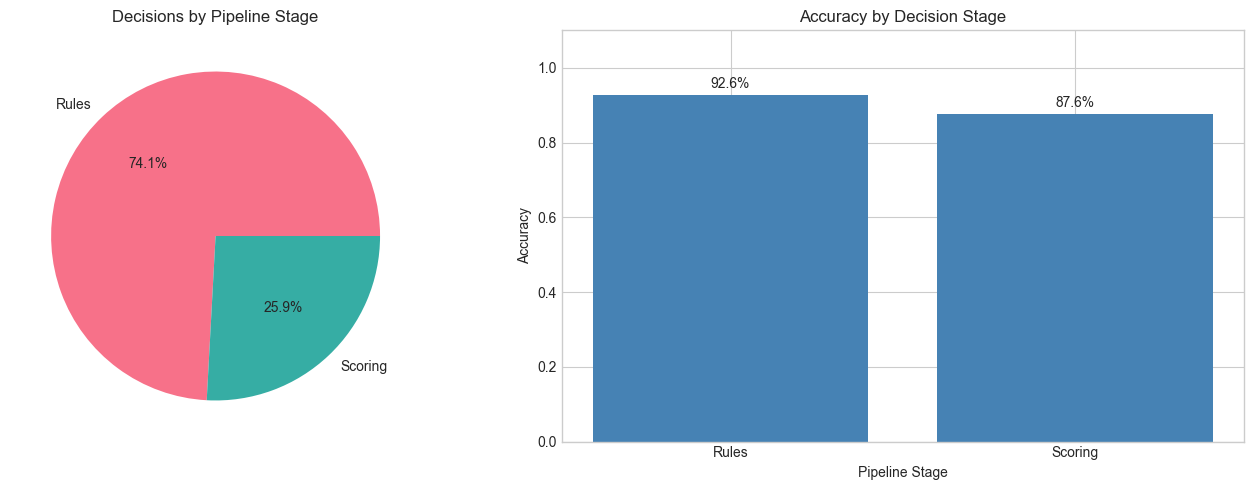

In [19]:
# Visualize stage distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart of decision stage distribution
ax1.pie(df_stages['Pairs'], labels=df_stages['Stage'], autopct='%1.1f%%',
        colors=sns.color_palette('husl', len(df_stages)))
ax1.set_title('Decisions by Pipeline Stage')

# Bar chart of accuracy by stage
ax2.bar(df_stages['Stage'], df_stages['Accuracy'], color='steelblue')
ax2.set_ylabel('Accuracy')
ax2.set_xlabel('Pipeline Stage')
ax2.set_title('Accuracy by Decision Stage')
ax2.set_ylim(0, 1.1)

for i, v in enumerate(df_stages['Accuracy']):
    ax2.text(i, v + 0.02, f'{v:.1%}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

## 10. Summary

Final evaluation summary and target achievement status.

In [17]:
# Final summary
print("=" * 70)
print("ENTITY RESOLUTION EVALUATION SUMMARY")
print("=" * 70)

print(f"\n{'Metric':<20} {'Value':>10}")
print("-" * 32)
print(f"{'Total Pairs':<20} {overall_metrics.total_pairs:>10}")
print(f"{'Accuracy':<20} {overall_metrics.accuracy:>10.2%}")
print(f"{'Precision':<20} {overall_metrics.precision:>10.2%}")
print(f"{'Recall':<20} {overall_metrics.recall:>10.2%}")
print(f"{'F1 Score':<20} {overall_metrics.f1_score:>10.2%}")

print("\n" + "=" * 70)
print("TARGET ACHIEVEMENT")
print("=" * 70)

all_passed = True
for diff in ['easy', 'medium', 'hard', 'ambiguous']:
    if diff in by_difficulty:
        m = by_difficulty[diff]
        target = targets[diff]
        passed = m.accuracy >= target
        status = '✓ PASS' if passed else '✗ FAIL'
        all_passed = all_passed and passed
        print(f"{diff.capitalize():<12} {m.accuracy:>6.1%} (target: {target:.0%}) [{status}]")

print("\n" + "=" * 70)
if all_passed:
    print("🎉 ALL TARGETS MET - Phase 2.5 Evaluation Complete!")
else:
    print("⚠️  Some targets not met - review error analysis above")
print("=" * 70)

ENTITY RESOLUTION EVALUATION SUMMARY

Metric                    Value
--------------------------------
Total Pairs                 437
Accuracy                 91.30%
Precision                92.53%
Recall                   97.55%
F1 Score                 94.97%

TARGET ACHIEVEMENT
Easy         100.0% (target: 95%) [✓ PASS]
Medium       100.0% (target: 85%) [✓ PASS]
Hard          92.4% (target: 70%) [✓ PASS]
Ambiguous     80.5% (target: 70%) [✓ PASS]

🎉 ALL TARGETS MET - Phase 2.5 Evaluation Complete!


In [18]:
# Export summary statistics
summary_stats = evaluator.get_summary_stats(results)

# Save to JSON for programmatic access
import json
output_path = project_root / 'data' / 'synthetic' / 'evaluation_results.json'
with open(output_path, 'w') as f:
    json.dump(summary_stats, f, indent=2)
print(f"Summary stats saved to: {output_path}")

Summary stats saved to: /Users/alex/repos/Kaggle/medmatch-ai/data/synthetic/evaluation_results.json


---

## Optional: Run with AI Enabled

To enable AI medical fingerprinting for ambiguous cases, uncomment and run the cell below.
**Note:** This requires a valid `GOOGLE_AI_API_KEY` in your `.env` file.

In [19]:
# Test AI is working - run this cell to verify
matcher_with_ai = PatientMatcher(
    use_blocking=True,
    use_rules=True,
    use_scoring=True,
    use_ai=True,
    api_rate_limit=0,  # No rate limiting (billing enabled)
)

print("Running with AI enabled...")
results_with_ai = matcher_with_ai.match_datasets(records, show_progress=True)

# Check stage distribution
by_stage = {}
for r in results_with_ai:
    by_stage[r.stage] = by_stage.get(r.stage, 0) + 1

print(f"\nDecisions by stage:")
for stage, count in sorted(by_stage.items()):
    print(f"  {stage}: {count} pairs")

# Show AI decisions specifically
ai_results = [r for r in results_with_ai if r.stage == 'ai']
print(f"\n{'='*60}")
print(f"AI STAGE DETAILS: {len(ai_results)} pairs processed by AI")
print(f"{'='*60}")

if ai_results:
    for i, r in enumerate(ai_results[:5], 1):  # Show first 5
        print(f"\n[{i}] {r.record_1_id} <-> {r.record_2_id}")
        print(f"    Match: {r.is_match}, Confidence: {r.confidence:.2f}")
        print(f"    Medical similarity: {r.medical_similarity}")
        print(f"    AI reasoning: {r.ai_reasoning[:150] if r.ai_reasoning else 'None'}...")
    if len(ai_results) > 5:
        print(f"\n... and {len(ai_results) - 5} more AI decisions")
else:
    print("\nNo pairs were sent to AI stage.")
    print("This means all pairs were resolved by rules or scoring with high confidence.")
    print("\nScoring results that ALMOST went to AI (scores 0.50-0.90):")
    ambiguous_scoring = [r for r in results_with_ai if r.stage == 'scoring' 
                         and 0.50 <= r.confidence <= 0.90]
    print(f"  Found {len(ambiguous_scoring)} ambiguous scoring results")
    
# Evaluate
metrics_with_ai = evaluator.evaluate(results_with_ai)
print(f"\nWith AI - Accuracy: {metrics_with_ai.accuracy:.2%}")

# Compare stages
by_stage_ai = evaluator.evaluate_by_stage(results_with_ai)
for stage, m in sorted(by_stage_ai.items()):
    print(f"  {stage}: {m.total_pairs} pairs, {m.accuracy:.2%} accuracy")

Running with AI enabled...
Blocking: 437 candidate pairs from 261 records (33930 total possible)


Matching pairs: 100%|██████████| 437/437 [06:12<00:00,  1.17it/s]


Decisions by stage:
  ai: 113 pairs
  rules: 324 pairs

AI STAGE DETAILS: 113 pairs processed by AI

[1] R0008 <-> R0009
    Match: True, Confidence: 0.81
    Medical similarity: 1.0
    AI reasoning: The medical histories for both patients are identical across all categories, including conditions, medications, surgeries, and allergies. There are no...

[2] R0001 <-> R0006
    Match: False, Confidence: 0.35
    Medical similarity: 0.0
    AI reasoning: There is no overlap in conditions, medications, surgeries, or allergies between Patient 1 and Patient 2. Their medical profiles are completely distinc...

[3] R0211 <-> R0213
    Match: True, Confidence: 0.75
    Medical similarity: 1.0
    AI reasoning: The medical histories for both patients are identical across all categories, including conditions, medications, surgeries, and allergies. Both have An...

[4] R0004 <-> R0005
    Match: True, Confidence: 0.85
    Medical similarity: 1.0
    AI reasoning: The medical histories are identi